In [4]:
# pip install pandas networkx altair vega numpy matplotlib tqdm

In [163]:
import pandas as pd
pd.set_option('display.max_columns', None)
import os
import json
import networkx as nx
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import itertools
import collections
from tqdm.notebook import trange, tqdm
import pathpy as pp
import teneto

In [2]:
#read in events csv
events_df = pd.read_csv('SCoData_events_v1.1_2021-01.csv')


In [3]:
# turn events into timestamped values
events_df['start_datetime'] = pd.to_datetime(events_df.start_date, format='%Y-%m-%d', errors='coerce')
events_df['end_datetime'] = pd.to_datetime(events_df.end_date, format='%Y-%m-%d', errors='coerce')
events_df['subscription_purchase_datetime'] = pd.to_datetime(events_df.subscription_purchase_date, format='%Y-%m-%d', errors='coerce')
events_df['index'] = events_df.index
events_df = events_df.reset_index(drop=True)

In [4]:
# copy and subset only events related to subscriptions
subscription_events = events_df.copy()
subscription_events = subscription_events[subscription_events.subscription_purchase_datetime.isna() ==False]
subset_subscription_events = subscription_events[['subscription_purchase_datetime','start_datetime', 'event_type', 'member_names', 'end_datetime', 'index']]

In [5]:
# subset only events related to borrowing and create separate year and month columns for grouping
borrow_events = events_df[(events_df.event_type == 'Borrow') & (events_df.start_date.str.len() > 9)]
borrow_events['year'] = borrow_events.start_datetime.dt.year
borrow_events['month'] = borrow_events.start_datetime.dt.month

/Users/EZCorp/workspace/shake_co/shake_co_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/EZCorp/workspace/shake_co/shake_co_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [6]:
# Merge borrow and subscription events to check if subscriptions where active when books where checked out
merged_borrows_subs = pd.merge(borrow_events, subset_subscription_events, on=['member_names'], how='left')
merged_borrows_subs['subscription_active'] = np.where(((merged_borrows_subs.subscription_purchase_datetime_y >= merged_borrows_subs.start_datetime_x )|(merged_borrows_subs.start_datetime_x <= merged_borrows_subs.end_datetime_y )), True, False)

In [7]:
# Clean out the merged dataframe to only include rows for borrow events
merged_borrows_subs = merged_borrows_subs[merged_borrows_subs.event_type_x=='Borrow']
merged_borrows_subs = merged_borrows_subs[['start_date', 'member_names', 'subscription_active', 'item_title', 'index_x']]
merged_borrows_subs = merged_borrows_subs[merged_borrows_subs.item_title.isna() == False]
merged_borrows_subs = merged_borrows_subs[merged_borrows_subs.duplicated() == False]

In [8]:
# Merge updated borrow events into original borrow events
merged_borrows_subs = merged_borrows_subs.rename(columns={'index_x':'index'})
updated_borrow_events = pd.merge(borrow_events, merged_borrows_subs, on=['index','start_date', 'member_names', 'item_title'], how='inner')

In [9]:
# Assign updated borrow events back to variable and get list of years before 1942 and all months
borrow_events = updated_borrow_events[updated_borrow_events.year < 1942]
years = borrow_events.year.unique().tolist()
months = borrow_events.month.unique().tolist()

In [11]:
borrow_events

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,subscription_volumes,subscription_category,subscription_purchase_date,reimbursement_refund,borrow_status,borrow_duration_days,purchase_price,currency,item_uri,item_title,item_volume,item_authors,item_year,item_notes,source_type,source_citation,source_manifest,source_image,start_datetime,end_datetime,subscription_purchase_datetime,index,year,month,subscription_active
0,Borrow,1919-11-18,1919-11-28,https://shakespeareandco.princeton.edu/members...,Denise Ulmann,"Ulmann, Denise",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,10.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/w...,De Profundis,NaN,"Wilde, Oscar",1905.0,NaN,Lending Library Card,"Sylvia Beach, Mlle Denise Ulmann Lending Libra...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/86...,1919-11-18,1919-11-28,NaT,7998,1919,11,True
1,Borrow,1919-11-18,1919-11-28,https://shakespeareandco.princeton.edu/members...,Denise Ulmann,"Ulmann, Denise",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,10.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/m...,Diana of the Crossways,NaN,"Meredith, George",1885.0,NaN,Lending Library Card,"Sylvia Beach, Mlle Denise Ulmann Lending Libra...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/86...,1919-11-18,1919-11-28,NaT,7999,1919,11,True
2,Borrow,1919-11-18,1919-11-22,https://shakespeareandco.princeton.edu/members...,Henri Regnier,"Regnier, Henri",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,4.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/h...,The Trumpet-Major,NaN,"Hardy, Thomas",1880.0,NaN,Lending Library Card,"Sylvia Beach, Henri Regnier Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/ce...,1919-11-18,1919-11-22,NaT,8000,1919,11,True
3,Borrow,1919-11-19,1919-11-22,https://shakespeareandco.princeton.edu/members...,Claude Cahun / Mlle Lucie Schwob,"Cahun, Claude",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,3.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/j...,Roderick Hudson,Vol. 1,"James, Henry",1875.0,NaN,Lending Library Card,"Sylvia Beach, Lucie Schwob Lending Library Car...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/3a...,1919-11-19,1919-11-22,NaT,8002,1919,11,True
4,Borrow,1919-11-19,1919-11-22,https://shakespeareandco.princeton.edu/members...,Maurice Oerthel,"Oerthel, Maurice",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,3.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/h...,Characters of Shakespeare's Plays,Vol. 1,"Hazlitt, William",1817.0,Published in the Everyman's Library series and...,Lending Library Card,"Sylvia Beach, Maurice Oerthel Lending Library ...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/ac...,1919-11-19,1919-11-22,NaT,8003,1919,11,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35474,Borrow,1941-12-12,1941-12-30,https://shakespeareandco.princeton.edu/members...,Commandant des Francs,"des Francs, Commandant",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,18.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/c...,The Box Office Murders,NaN,"Crofts, Freeman Wills",1929.0,NaN,Lending Library Card,"Sylvia Beach, des Francs Lending Library Card,...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/23...,1941-12-12,1941-12-30,NaT,34632,1941,12,False
35475,Borrow,1941-12-12,1941-12-30,https://shakespeareandco.princeton.edu/members...,Commandant des Francs,"des Francs, Commandant",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,18.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/c...,The Box Office Murders,NaN,"Crofts, Freeman Wills",1929.0,NaN,Lend

In [78]:
# borrow_events['start_time'] = (borrow_events.start_datetime - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
# 


In [13]:
# first_day = borrow_events.sort_values(by=['start_datetime'])[0:1].start_datetime.values[0]

In [14]:

# G = nx.Graph()
# for index, row in borrow_events[(borrow_events.item_title.isna()==False)&(borrow_events.year == 1919)].iterrows():
#     G.add_node(row.member_names, group='members', label=row.member_names)
#     G.add_node(row.item_title, group='books', label=row.item_title)
#     G.add_edge(row.member_names, row.item_title, label=str(row.year)+'_'+str(row.month), timestamp=)
#     nt.add_edge(row.member_names, row.item_title, label = str(row.year)+'_'+str(row.month))

In [12]:
# Group members and books by years and months
members_grouped = borrow_events[(borrow_events.item_title.isna()==False)].groupby([borrow_events.year,borrow_events.month, borrow_events.item_title])['member_names'].apply(list).reset_index(name='list_members')

books_grouped = borrow_events[(borrow_events.item_title.isna()==False)].groupby([borrow_events.year,borrow_events.month, borrow_events.member_names])['item_title'].apply(list).reset_index(name='list_books')



In [203]:
temporal_networks_R = borrow_events[borrow_events.borrow_duration_days.isna() == False]
temporal_networks_R[['start_date', 'end_date']]

In [96]:
def create_members_network(rows, graph):
    '''Create a graph from all members using shared books to connect members'''
    combos = list(itertools.combinations(rows.list_members, 2))
    if len(combos) > 0:
        graph.add_nodes_from(rows.list_members, item_title = rows.item_title, year=rows.year, month=rows.month)
        graph.add_edges_from(combos, item_title = rows.item_title, year=rows.year, month=rows.month)
    if len(combos) == 0:
        graph.add_nodes_from(rows.list_members, item_title = rows.item_title, year=rows.year, month=rows.month, index=rows.name)

def create_books_network(rows, graph):
    '''Create a graph from all books using members who read the same book as an edges'''
    combos = list(itertools.combinations(rows.list_books, 2))
#     print(combos)
    if len(combos) > 0:
        for c in combos:
            
            source_node = c[0]
            target_node = c[1]
#             print(c, str(rows.year) + '_' +str(rows.month), graph.has_edge(source_node, target_node))
#             time = str(rows.year) + '_' +str(rows.month)
            if source_node not in graph:
                graph.add_node(source_node)
            if target_node not in graph:
                graph.add_node(target_node)
            if (graph.has_edge(source_node, target_node) == False):
                graph.add_edge(source_node, target_node, year=rows.year, month=rows.month, weight=0)
            if (graph.has_edge(source_node, target_node) == True):
                if (rows.year == graph[source_node][target_node]['year']) and (rows.month == graph[source_node][target_node]['month']):
                    graph.add_edge(source_node, target_node, year=rows.year, month=rows.month, weight=graph[source_node][target_node]['weight']+1)

    if len(combos) == 0:
        graph.add_nodes_from(rows.list_books, t=str(rows.year) + '_' +str(rows.month))




In [92]:
def get_network_metrics(graph):
    '''Run network metrics for each node at various snapshots'''
    if nx.is_empty(graph):
        return graph
    else:
        degree = nx.degree_centrality(graph)
        eigenvector = nx.eigenvector_centrality_numpy(graph, max_iter=600)
        closeness = nx.closeness_centrality(graph)
        betweenness = nx.betweenness_centrality(graph)
        harmonic = nx.harmonic_centrality(graph)
        for d, v in graph.nodes(data=True):
            if 'member_name' in v:
                check_sub_status = borrow_events[(borrow_events.item_title == d) & (borrow_events.member_names == v['member_name']) & (borrow_events.year == v['year']) & (borrow_events.month == v['month'])]
            if 'item_title' in v:
                check_sub_status = borrow_events[(borrow_events.member_names == d) & (borrow_events.item_title == v['item_title']) & (borrow_events.year == v['year']) & (borrow_events.month == v['month'])]
            v['subscription_active'] = check_sub_status.subscription_active.values[0]
            v['degree'] = degree[d]
            v['eigenvector'] = eigenvector[d]
            v['closeness'] = closeness[d]
            v['betweenness'] = betweenness[d]
            v['harmonic'] = harmonic[d]
            v['node_title'] = d
        return graph

In [197]:
# Process the borrowers graph through the network metrics and return dataframes for each month and each year
books_dfs = []
members_dfs = []
month_ranges = [{'Winter':[12,1,2]},{'Spring':[3,4,5]}, {'Summer': [6,7,8]}, {'Fall': [9,10,11]}]
for year in tqdm(years[0:6]):
    for month in month_ranges:
        print(year, month)
         # Make books graph for each month range
        book_graph = nx.Graph()
        books_grouped[(books_grouped.year == year) & (books_grouped.month.isin(list(month.values())[0]))].apply(create_books_network, graph=book_graph, axis=1)
        book_graph.remove_edges_from(nx.selfloop_edges(book_graph))
        books_df = nx.to_pandas_edgelist(book_graph )
        books_df['seasons'] = list(month.keys())[0]
        books_dfs.append(books_df)

#         # Make members graph for each month range
#         member_graph = nx.Graph()
#         members_grouped[(members_grouped.year == year) & (members_grouped.month.isin(list(month.values())[0]))].apply(create_members_network, graph=member_graph, axis=1)
#         member_graph.remove_edges_from(nx.selfloop_edges(member_graph))
# #         members_graph_processed = get_network_metrics(member_graph)
#         members_graph_processed = member_graph
#         members_df = pd.DataFrame.from_dict(dict(members_graph_processed.nodes(data=True)), orient='index').reset_index(drop=True)
#         members_df['seasons'] = list(month.keys())[0]
#         members_dfs.append(members_df)

  0%|          | 0/6 [00:00<?, ?it/s]

1919 {'Winter': [12, 1, 2]}
1919 {'Spring': [3, 4, 5]}
1919 {'Summer': [6, 7, 8]}
1919 {'Fall': [9, 10, 11]}
1920 {'Winter': [12, 1, 2]}
1920 {'Spring': [3, 4, 5]}
1920 {'Summer': [6, 7, 8]}
1920 {'Fall': [9, 10, 11]}
1921 {'Winter': [12, 1, 2]}
1921 {'Spring': [3, 4, 5]}
1921 {'Summer': [6, 7, 8]}
1921 {'Fall': [9, 10, 11]}
1922 {'Winter': [12, 1, 2]}
1922 {'Spring': [3, 4, 5]}
1922 {'Summer': [6, 7, 8]}
1922 {'Fall': [9, 10, 11]}
1923 {'Winter': [12, 1, 2]}
1923 {'Spring': [3, 4, 5]}
1923 {'Summer': [6, 7, 8]}
1923 {'Fall': [9, 10, 11]}
1924 {'Winter': [12, 1, 2]}
1924 {'Spring': [3, 4, 5]}
1924 {'Summer': [6, 7, 8]}
1924 {'Fall': [9, 10, 11]}


In [198]:
joined_books_dfs = pd.concat(books_dfs)
joined_books_dfs

,source,target,weight,month,year,seasons
0,Colors of Life: Poems and Songs and Sonnets,Speculative Dialogues,1.0,12.0,1919.0,Winter
1,Playboy: A Portfolio of Art and Satire,Heartbreak House: A Fantasia in the Russian Ma...,1.0,12.0,1919.0,Winter
2,Playboy: A Portfolio of Art and Satire,The Shadow Line: A Confession,1.0,12.0,1919.0,Winter
3,Playboy: A Portfolio of Art and Satire,The Story of Yone Noguchi: Told by Himself,2.0,12.0,1919.0,Winter
4,Playboy: A Portfolio of Art and Satire,The American Diary of a Japanese Girl,1.0,12.0,1919.0,Winter
...,...,...,...,...,...,...
326,Swann's Way (À la recherche du temps perdu 1),The Life of Olive Schreiner,1.0,11.0,1924.0,Fall
327,Swann's Way (À la recherche du temps perdu 1),Gold,1.0,11.0,1924.0,Fall
328,The Life of Olive Schreiner,Gold,1.0,11.0,1924.0,Fall
329,Man and Superman,The Crock of Gold,4.0,11.0,1924.0,Fall


In [181]:
time_df = joined_books_dfs[['year', 'seasons']]
time_df = time_df.drop_duplicates()
time_df = time_df.reset_index(drop=True)
time_df['t'] = time_df.index
time_df

,year,seasons,t
0,1919.0,Winter,0
1,1919.0,Fall,1
2,1920.0,Winter,2
3,1920.0,Spring,3
4,1920.0,Summer,4
5,1920.0,Fall,5
6,1921.0,Winter,6
7,1921.0,Spring,7
8,1921.0,Summer,8
9,1921.0,Fall,9


In [182]:
temporal_df = pd.merge(joined_books_dfs, time_df, on=['year', 'seasons'])

In [183]:
temporal_df = temporal_df.rename(columns={'source': 'i', 'target': 'j'})

In [184]:
test = temporal_df[['i','j','t', 'weight']]
test

,i,j,t,weight
0,0.0,1.0,0,1.0
1,2.0,3.0,0,1.0
2,2.0,4.0,0,1.0
3,2.0,5.0,0,2.0
4,2.0,6.0,0,1.0
...,...,...,...,...
4939,121.0,122.0,21,1.0
4940,121.0,123.0,21,1.0
4941,122.0,123.0,21,1.0
4942,124.0,125.0,21,4.0


In [185]:
tnet = teneto.TemporalNetwork(from_df=test)

/Users/EZCorp/workspace/shake_co/shake_co_env/lib/python3.7/site-packages/teneto/classes/network.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.network['i'] = self.network['i'].astype(int)
/Users/EZCorp/workspace/shake_co/shake_co_env/lib/python3.7/site-packages/teneto/classes/network.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.network['j'] = self.network['j'].astype(int)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:xlabel='Time'>

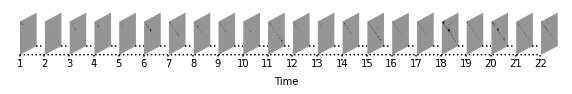

In [190]:
fig, ax = plt.subplots(figsize=(10,3))
# this creates a numpy array of node,node,time (all teneto functions work with this)
network = tnet.df_to_array()

# teneto.plot.graphlet_stack_plot(C,ax,q=10,cmap='Greys')
teneto.plot.graphlet_stack_plot(network, ax, vminmax=[-1,1], borderwidth=0, q=10,cmap='Greys')

In [193]:
testing = networkmeasures.temporal_degree_centrality(tnet, calc='pertime')

In [196]:
for index, t in enumerate(testing):
    print(index, t)

0 [ 1.  1.  3.  0.  1.  1.  0.  1.  1.  2.  0.  4.  1.  5.  6. 14.  0.  0.
 14.  1.  0.  0.]
1 [ 0.  0.  2.  1.  0.  4.  8.  0.  0.  2.  9.  3.  0.  4. 14. 11.  3.  0.
  2.  0.  4.  7.]
2 [ 4.  1.  1.  0.  2.  3.  0.  1.  0.  0. 10.  2.  1. 10.  6.  5.  2.  9.
  1.  8.  3.  6.]
3 [ 9.  0.  5.  1.  1.  2.  6.  0.  4.  9.  2.  1.  4.  8. 17.  4.  1.  0.
  0.  7.  2.  5.]
4 [12.  1.  3.  0.  0.  1.  5.  0.  2.  1.  1.  0.  2. 13.  2.  3.  4. 20.
 10.  6.  1.  4.]
5 [ 1.  0.  2.  1.  0.  0.  4.  1.  1.  0.  0.  1.  1.  0. 10.  6.  1. 23.
  9.  5.  0. 21.]
6 [ 0.  0.  1.  0.  2.  1.  3.  0.  0.  0.  3.  0.  0.  2.  0.  3.  0. 18.
 10.  8.  1.  2.]
7 [ 1.  1.  0.  1.  1.  2.  2.  1.  1.  4.  2.  1.  3.  0.  0.  0.  1. 17.
  7.  3.  9.  1.]
8 [ 0.  0.  0.  0.  0.  0.  1.  0.  1.  3.  1.  0.  2.  0.  2.  2.  0. 16.
  6.  2.  1.  8.]
9 [ 0.  0.  0.  4.  2.  0.  2.  6.  0.  2.  3.  1.  1.  1.  1.  6.  0. 15.
 10.  1.  0.  3.]
10 [ 4.  0.  3. 11.  1.  1.  5.  5.  2.  1.  1.  0.  0.  0.  0.  3.  3

In [22]:
# Join the processed dataframes and then melt them 
joined_books_dfs = pd.concat(books_dfs)
joined_books_dfs = joined_books_dfs.drop('index', axis=1)

joined_members_dfs = pd.concat(members_dfs)
joined_members_dfs = joined_members_dfs.drop('index', axis=1)

# melted_books_dfs = pd.melt(joined_books_dfs, id_vars=['member_name', 'node_title', 'year', 'month', 'subscription_active', 'seasons'])
# melted_members_dfs = pd.melt(joined_members_dfs, id_vars=['item_title', 'node_title', 'year', 'month', 'subscription_active', 'seasons'])

In [24]:
joined_books_dfs

,member_name,year,month,seasons
0,André Maurois,1919.0,12.0,Winter
1,André Maurois,1919.0,12.0,Winter
2,Blanche Reverchon,1919.0,12.0,Winter
3,Madeleine Rolland,1919.0,12.0,Winter
4,Raymonde Linossier,1919.0,12.0,Winter
5,Blanche Reverchon,1919.0,12.0,Winter
6,Blanche Reverchon,1919.0,12.0,Winter
7,Denise Ulmann,1919.0,12.0,Winter
8,Denise Ulmann,1919.0,12.0,Winter
9,Mlle de Pfeffel,1919.0,12.0,Winter


In [91]:
# Average each of the metrics by season and compare rates by metric, members vs books, and across years. 
# Click on the legend years to highlight lines and hover on the points to get more info for each season
alt.data_transformers.disable_max_rows()
selection = alt.selection_multi(fields=['year'], bind='legend')
chart = alt.Chart(melted_members_dfs[melted_members_dfs.variable != 'subgraph']).mark_line(point=True).encode(
    x='month_bins',
    y=alt.Y('mean(value):Q', axis=alt.Axis(title='')),
    color=alt.Color('year:N', scale=alt.Scale(scheme='plasma')),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    column='variable',
    tooltip=['month_bins', 'variable', 'mean(value)', 'year']
).add_selection(
    selection
).properties(
    height=250,
    width=250,
    title='Each Metric of the Members Graph Averaged by Season and Colored by Year'
).resolve_scale(x='independent', y='independent')

selection_1 = alt.selection_multi(fields=['year'], bind='legend')
chart_1 = alt.Chart(melted_books_dfs[melted_books_dfs.variable != 'subgraph']).mark_line(point=True).encode(
    x='month_bins',
    y=alt.Y('mean(value):Q', axis=alt.Axis(title='')),
    color=alt.Color('year:N', scale=alt.Scale(scheme='plasma')),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    column='variable',
    tooltip=['month_bins', 'variable', 'mean(value)', 'year']
).add_selection(
    selection
).properties(
    height=250,
    width=250,
    title='Each Metric of the Books Graph Averaged by Season and Colored by Year'
).resolve_scale(x='independent', y='independent')

alt.vconcat(chart, chart_1)

Output hidden; open in https://colab.research.google.com to view.

In [94]:
# Delve into individual metrics per node for both books and members
# You can compare 
field_1 = 'degree'
field_2 = 'betweenness'
base = alt.Chart(joined_members_dfs).encode(
    x=f'{field_1}:Q',
    y=f'{field_2}:Q',
).properties(
    height=50,
    width=50,
)

selection = alt.selection_single(fields=['node_title'])
chart = alt.layer(
    base.mark_circle().encode(
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
        tooltip=['node_title', f'{field_1}', f'{field_2}']
    ),
    base.transform_regression(f'{field_1}', f'{field_2}').mark_line()
).add_selection(selection).facet(
    column='month_bins',
    row='year'
).properties(title='Comparing Graph Metrics for Each Member by Seasons and Year').resolve_scale(x='independent', y='independent')

base_1 = alt.Chart(joined_books_dfs).encode(
    x=f'{field_1}:Q',
    y=f'{field_2}:Q',
).properties(
    height=50,
    width=50,
)

selection_1 = alt.selection_single(fields=['node_title'])
chart_1 = alt.layer(
    base_1.mark_circle().encode(
        opacity=alt.condition(selection_1, alt.value(1), alt.value(0.2)),
        tooltip=['node_title', f'{field_1}', f'{field_2}']
    ),
    base_1.transform_regression(f'{field_1}', f'{field_2}').mark_line()
).add_selection(selection_1).facet(
    column='month_bins',
    row='year'
).properties(title='Comparing Graph Metrics for Each Book by Seasons and Year').resolve_scale(x='independent', y='independent')

alt.hconcat(chart, chart_1)

Output hidden; open in https://colab.research.google.com to view.

In [95]:

chart = alt.Chart(joined_members_dfs).mark_bar(size=2).encode(
    x='degree:Q',
    y=alt.Y('count():Q', axis=alt.Axis(title='')),
    color=alt.Color('subscription_active', scale=alt.Scale(scheme='plasma')),
    column='month_bins',
    row='year'
).properties(
    height=50,
    width=50,
    title='The Degree Centrality of All Members Linked by Shared Books'
).resolve_scale(x='independent', y='independent')

chart_1 = alt.Chart(joined_books_dfs).mark_bar(size=2).encode(
    x='degree:Q',
    y=alt.Y('count():Q', axis=alt.Axis(title='')),
    color=alt.Color('subscription_active', scale=alt.Scale(scheme='plasma')),
    column='month_bins',
    row='year'
).properties(
    height=50,
    width=50,
    title='The Degree Centrality of All Books Read and Linked by Shared Members'
).resolve_scale(x='independent', y='independent')
alt.hconcat(chart, chart_1)
# chart.save('books_degree_over_time_scale_dependent.png', scale_factor=2.0)

Output hidden; open in https://colab.research.google.com to view.

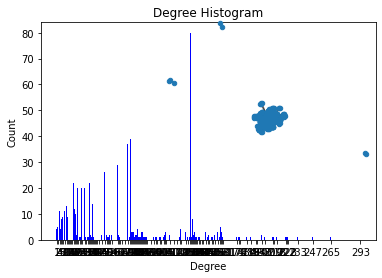

In [ ]:
book_graph = nx.Graph()
books_grouped.apply(create_books_network, graph=book_graph, axis=1)
degree_sequence = sorted([d for n, d in book_graph.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="b")

plt.title("Degree Histogram for Entire Books Network")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = G.subgraph(sorted(nx.connected_components(book_graph), key=len, reverse=True)[0])
pos = nx.spring_layout(first_graph)
plt.axis("off")
nx.draw_networkx_nodes(first_graph, pos, node_size=20)
nx.draw_networkx_edges(first_graph, pos, alpha=0.4)
plt.show()

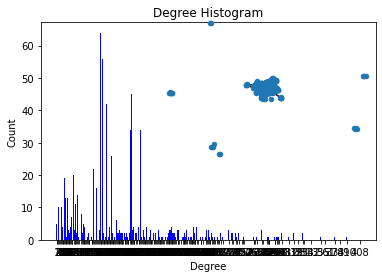

In [ ]:
members_graph = nx.Graph()
members_grouped.apply(create_members_network, graph=members_graph, axis=1)
degree_sequence = sorted([d for n, d in members_graph.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="b")

plt.title("Degree Histogram for Entire Members Network")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = G.subgraph(sorted(nx.connected_components(members_graph), key=len, reverse=True)[0])
pos = nx.spring_layout(second_graph)
plt.axis("off")
nx.draw_networkx_nodes(second_graph, pos, node_size=20)
nx.draw_networkx_edges(second_graph, pos, alpha=0.4)
plt.show()